# OpenML CC18 Metalearning Benchmark

This notebook looks at the training and test results of an experiment
tuning the controller entropy coefficient to assess performance as a function
of the learning rate hyperparemeter.

In [1]:
%matplotlib inline

In [2]:
import re
import tarfile

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandera as pa
import plotly.express as px
import seaborn as sns
import yaml
from IPython.display import display, Markdown

from pathlib import Path

In [3]:
# environment variables

JOB = 371
RESULTS_ROOT = Path("..") / "floyd_outputs"
OUTPUT_PATH = RESULTS_ROOT / str(JOB) / "output.tar"

#### Experiment Config

In [7]:
with tarfile.open(OUTPUT_PATH) as tar:
    file = tar.extractfile(tar.getmember("./experiment_config.yml"))
    experiment_config = yaml.safe_load(file)
    
print(json.dumps(experiment_config, indent=4))

{
    "name": "metalearn_a2c_binary",
    "experiment_type": "METALEARN_REINFORCE",
    "description": "metalearning with A2C architecture",
    "created_at": "2020-01-20-16-56-31",
    "git_hash": "633ce78",
    "parameters": {
        "datasets": null,
        "test_datasets": null,
        "output_fp": "/output",
        "input_size": 30,
        "hidden_size": 30,
        "output_size": 30,
        "n_layers": 3,
        "dropout_rate": 0.2,
        "entropy_coef": 0.01,
        "entropy_coef_anneal_to": 0.0,
        "entropy_coef_anneal_by": null,
        "normalize_reward": false,
        "gamma": 0.99,
        "meta_reward_multiplier": 1.0,
        "n_episodes": 250,
        "n_iter": 50,
        "n_eval_iter": 50,
        "learning_rate": 0.005,
        "optim_beta1": 0.9,
        "optim_beta2": 0.999,
        "env_sources": [
            "SKLEARN",
            "OPEN_ML",
            "AUTOSKLEARN_BENCHMARK"
        ],
        "test_env_sources": [
            "OPEN_ML_BENCHMARK

## Training Metrics

In [8]:
with tarfile.open(OUTPUT_PATH) as tar:
    training_result_files = [
        m for m in tar.getmembers()
        if m.name.startswith("./metalearn_training_results_trial_")
    ]
    training_results = (
        pd.concat([
            pd.read_csv(tar.extractfile(member))
            for member in training_result_files
        ])
        .sort_values(["trial_num", "episode"])
    )

training_results.head(3)

,episode,data_env_names,target_type,scorers,total_losses,actor_losses,critic_losses,entropy_losses,gradient_norms,mean_rewards,...,std_validation_scores,best_validation_scores,n_successful_mlfs,n_unique_mlfs,n_unique_hyperparams,mlf_diversity,hyperparam_diversity,entropy_coefficient,trial_num,entropy_coef
0,1,openml.kddcup09_churn,BINARY,roc_auc,276.579163,-25.892496,302.483673,-0.012031,1.00000,-1.000000,...,NaN,NaN,0,0,0,NaN,NaN,0.01,0,0.01
1,2,openml.sylva_agnostic,BINARY,roc_auc,0.885188,-2.524018,3.421308,-0.012103,0.95571,-0.036038,...,0.20662,0.990177,28,26,28,0.925926,1.0,0.01,0,0.01
2,3,openml.kddcup09_appetency,BINARY,roc_auc,275.065735,-25.977833,301.055481,-0.011896,1.00000,-1.000000,...,NaN,NaN,0,0,0,NaN,NaN,0.01,0,0.01


### Mean Rewards per Episode

It looks like the experiment output is missing training results
data for trials 1, 2, 3, and 6. Not sure why this happened, need
to check that the trail numbers are properly recorded in the
`metalearn.experiment` module.

In [9]:
training_results.query("episode == 1")

,episode,data_env_names,target_type,scorers,total_losses,actor_losses,critic_losses,entropy_losses,gradient_norms,mean_rewards,...,std_validation_scores,best_validation_scores,n_successful_mlfs,n_unique_mlfs,n_unique_hyperparams,mlf_diversity,hyperparam_diversity,entropy_coefficient,trial_num,entropy_coef
0,1,openml.kddcup09_churn,BINARY,roc_auc,276.579163,-25.892496,302.483673,-0.012031,1.0,-1.0,...,NaN,NaN,0,0,0,NaN,NaN,0.01,0,0.01
0,1,openml.kddcup09_churn,BINARY,roc_auc,276.970978,-25.164982,302.170258,-0.034294,1.0,-1.0,...,NaN,NaN,0,0,0,NaN,NaN,0.03,1,0.03
0,1,openml.kddcup09_churn,BINARY,roc_auc,276.113647,-25.453226,301.685211,-0.118357,1.0,-1.0,...,NaN,NaN,0,0,0,NaN,NaN,0.10,2,0.10
0,1,openml.kddcup09_churn,BINARY,roc_auc,276.508301,-26.137255,303.009613,-0.364039,1.0,-1.0,...,NaN,NaN,0,0,0,NaN,NaN,0.30,3,0.30


In [10]:
training_results.trial_num.unique()

array([0, 1, 2, 3])

In [11]:
HYPERPARAMETERS = ["entropy_coefficient"]

trial_num_map = (
    training_results[["trial_num"] + HYPERPARAMETERS].drop_duplicates()
    .set_index("trial_num")
    .to_dict(orient="index")
)
trial_num_map

{0: {'entropy_coefficient': 0.01},
 1: {'entropy_coefficient': 0.03},
 2: {'entropy_coefficient': 0.1},
 3: {'entropy_coefficient': 0.3}}

Roughly define regret as ${validation\ score}_{max} - {validation\ score}_{mean}$
for a particular episode. Where ${validation\ score}_{max}$ is the best validation
set found by all of the hyperparameter conditions for a particular dataset.

In [9]:
optimal_validation_scores = training_results.groupby("data_env_names").best_validation_scores.max()

training_results.assign(optimal_validation_scores=lambda df: df.data_env_names.map(optimal_validation_scores))

,episode,data_env_names,target_type,scorers,total_losses,actor_losses,critic_losses,entropy_losses,gradient_norms,mean_rewards,...,best_validation_scores,n_successful_mlfs,n_unique_mlfs,n_unique_hyperparams,mlf_diversity,hyperparam_diversity,entropy_coefficient,trial_num,entropy_coef,optimal_validation_scores
0,1,openml.kddcup09_churn,BINARY,roc_auc,276.579163,-25.892496,302.483673,-0.012031,1.000000,-1.000000,...,NaN,0,0,0,NaN,NaN,0.01,0,0.01,NaN
1,2,openml.sylva_agnostic,BINARY,roc_auc,0.885188,-2.524018,3.421308,-0.012103,0.955710,-0.036038,...,0.990177,28,26,28,0.925926,1.0,0.01,0,0.01,0.998872
2,3,openml.kddcup09_appetency,BINARY,roc_auc,275.065735,-25.977833,301.055481,-0.011896,1.000000,-1.000000,...,NaN,0,0,0,NaN,NaN,0.01,0,0.01,NaN
3,4,openml.labor,BINARY,roc_auc,16.024292,-6.252566,22.288795,-0.011938,1.000000,-0.311078,...,1.000000,20,19,20,0.947368,1.0,0.01,0,0.01,1.000000
4,5,openml.elevators,BINARY,roc_auc,0.974592,-0.518504,1.505145,-0.012050,0.999999,-0.024218,...,0.832415,30,27,30,0.896552,1.0,0.01,0,0.01,0.944900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,openml.analcatdata_supreme,BINARY,roc_auc,12.326629,1.599913,11.047264,-0.320548,1.000000,0.215715,...,1.000000,34,28,34,0.818182,1.0,0.30,3,0.30,1.000000
246,247,openml.bank32nh,BINARY,roc_auc,15.964289,-3.604096,19.895042,-0.326658,1.000000,0.226457,...,0.884785,38,36,38,0.945946,1.0,0.30,3,0.30,0.901645
247,248,openml.pol,BINARY,roc_auc,16.092930,-2.095102,18.512064,-0.324032,1.000000,-0.050549,...,0.994438,27,21,27,0.769231,1.0,0.30,3,0.30,0.996623
248,249,openml.click_prediction_small,BINARY,roc_auc,17.093575,-5.145095,22.561979,-0.323308,1.000000,-0.110230,...,0.640286,29,25,29,0.857143,1.0,0.30,3,0.30,0.672934


Are the `data_env_names` being sampled in the same order?

In [10]:
(
    training_results
    .pivot(index="episode", columns="trial_num", values="data_env_names")
    .pipe(lambda s: s[0] == s[1]).all()
)

True

In [11]:
METRICS = [
    "total_losses",
    "gradient_norms",
    "best_validation_scores",
    "mean_rewards",
    "mean_validation_scores",
    "n_successful_mlfs",
    "n_unique_mlfs",
    "mlf_diversity",
    "hyperparam_diversity",
]


agg_performance_results = (
    training_results
    # get rank by mean validation scores
    .sort_values(["episode", "mean_validation_scores"], ascending=[True, False])
    .groupby("episode")
    .apply(lambda group: group.assign(rank_mean_validation_score=range(1, group.shape[0] + 1)))
    .reset_index(drop=True)
    # get rank by best validation score
    .sort_values(["episode", "best_validation_scores"], ascending=[True, False])
    .groupby("episode")
    .apply(lambda group: group.assign(rank_best_validation_score=range(1, group.shape[0] + 1)))
    .reset_index(drop=True)
    # compute regret
    .assign(
        optimal_validation_scores=lambda df: df.data_env_names.map(
            training_results.groupby("data_env_names").best_validation_scores.max())
    )
    .assign(regret=lambda df: df.optimal_validation_scores - df.mean_validation_scores)
    .groupby(["trial_num"] + HYPERPARAMETERS)
    # compute cumulative metrics
    .apply(
        lambda df: df.assign(
            cum_regret=df.regret.cumsum(),
            cum_rank_mean_validation_score=df.rank_mean_validation_score.cumsum(),
            cum_rank_best_validation_score=df.rank_best_validation_score.cumsum(),
        )
    )
    .reset_index(drop=True)
    .assign(
        trial_info=lambda df: (
            "trial = " + df.trial_num.astype(str) +
            "; entropy_coefficient = " + df.entropy_coefficient.astype(str)
        )
    )
    # compute exponentially-weighted mean of metrics
    .pipe(lambda df: pd.concat([
        df,
        (
            df
            .set_index(["trial_info", "episode"])
            .groupby("trial_info")
            .apply(lambda df: df[METRICS].ewm(alpha=0.05).mean())
            .rename(columns={m: f"ewm_{m}" for m in METRICS})
            .reset_index(drop=True)
        )
    ], sort=False, axis=1))
    .reset_index(drop=True)
)

agg_performance_results.head()

,episode,data_env_names,target_type,scorers,total_losses,actor_losses,critic_losses,entropy_losses,gradient_norms,mean_rewards,...,trial_info,ewm_total_losses,ewm_gradient_norms,ewm_best_validation_scores,ewm_mean_rewards,ewm_mean_validation_scores,ewm_n_successful_mlfs,ewm_n_unique_mlfs,ewm_mlf_diversity,ewm_hyperparam_diversity
0,1,openml.kddcup09_churn,BINARY,roc_auc,276.579163,-25.892496,302.483673,-0.012031,1.000000,-1.000000,...,trial = 0; entropy_coefficient = 0.01,276.579163,1.000000,NaN,-1.000000,NaN,0.000000,0.000000,NaN,NaN
1,2,openml.sylva_agnostic,BINARY,roc_auc,0.885188,-2.524018,3.421308,-0.012103,0.955710,-0.036038,...,trial = 0; entropy_coefficient = 0.01,135.197637,0.977287,0.990177,-0.505661,0.721360,14.358974,13.333333,0.925926,1.0
2,3,openml.kddcup09_appetency,BINARY,roc_auc,275.065735,-25.977833,301.055481,-0.011896,1.000000,-1.000000,...,trial = 0; entropy_coefficient = 0.01,184.231151,0.985250,0.990177,-0.678961,0.721360,9.325153,8.659071,0.925926,1.0
3,4,openml.labor,BINARY,roc_auc,16.024292,-6.252566,22.288795,-0.011938,1.000000,-0.311078,...,trial = 0; entropy_coefficient = 0.01,138.890847,0.989226,0.995340,-0.579798,0.721857,12.202567,11.446477,0.937197,1.0
4,5,openml.elevators,BINARY,roc_auc,0.974592,-0.518504,1.505145,-0.012050,0.999999,-0.024218,...,trial = 0; entropy_coefficient = 0.01,108.407948,0.991607,0.937305,-0.457001,0.687821,16.136240,14.884190,0.922719,1.0


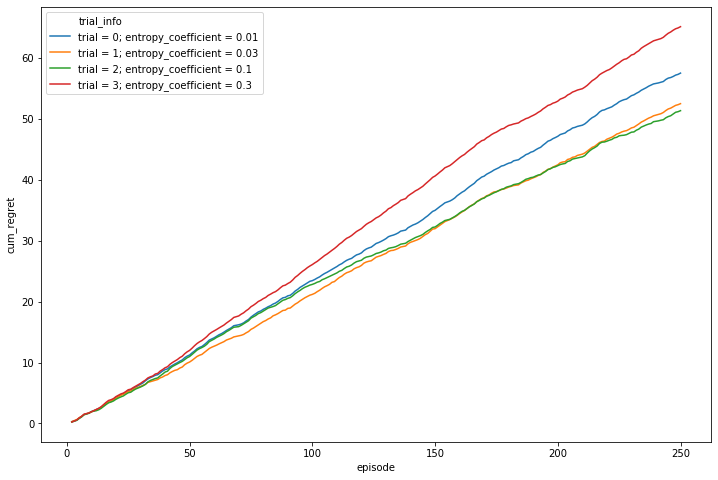

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="cum_regret",
    hue="trial_info",
    ax=ax,
)

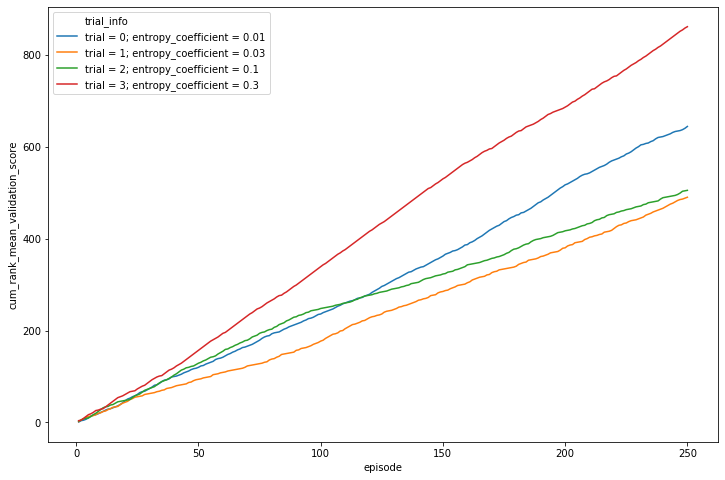

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="cum_rank_mean_validation_score",
    hue="trial_info",
    ax=ax,
)

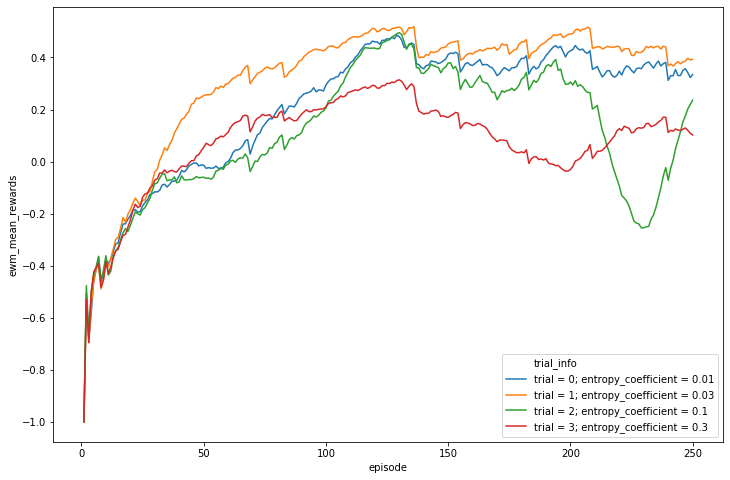

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="ewm_mean_rewards",
    hue="trial_info",
    ax=ax,
)

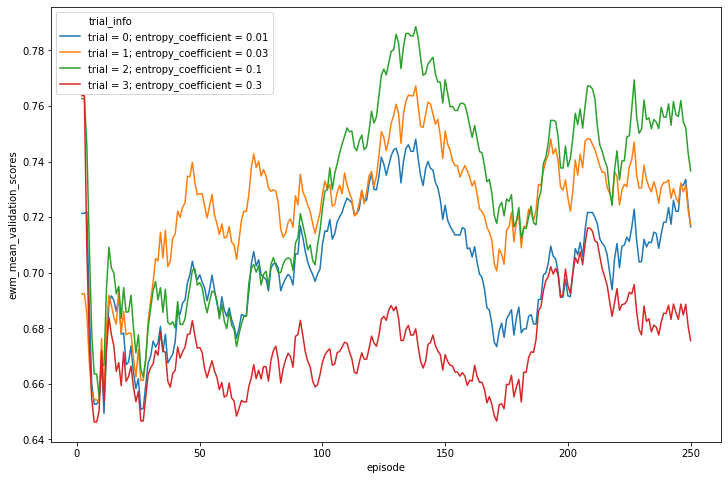

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="ewm_mean_validation_scores",
    hue="trial_info",
    ax=ax,
)

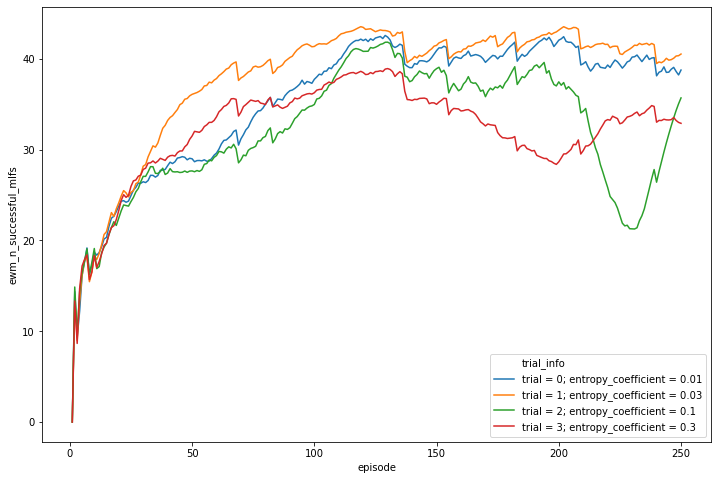

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="ewm_n_successful_mlfs",
    hue="trial_info",
    ax=ax,
)

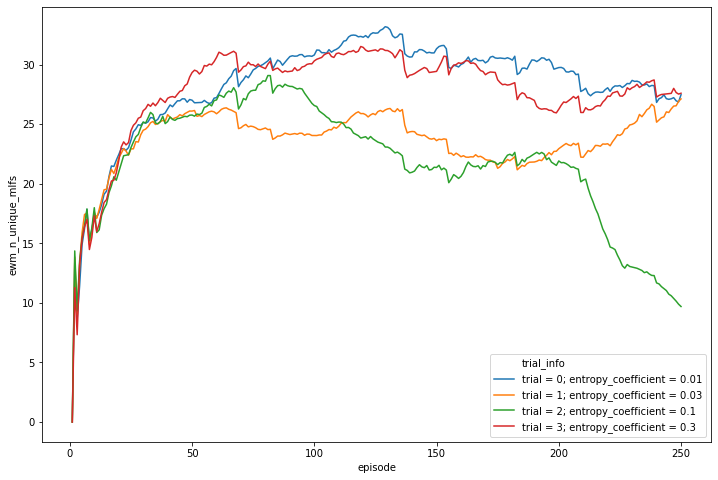

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="ewm_n_unique_mlfs",
    hue="trial_info",
    ax=ax,
)

### Mean Reward per Dataset

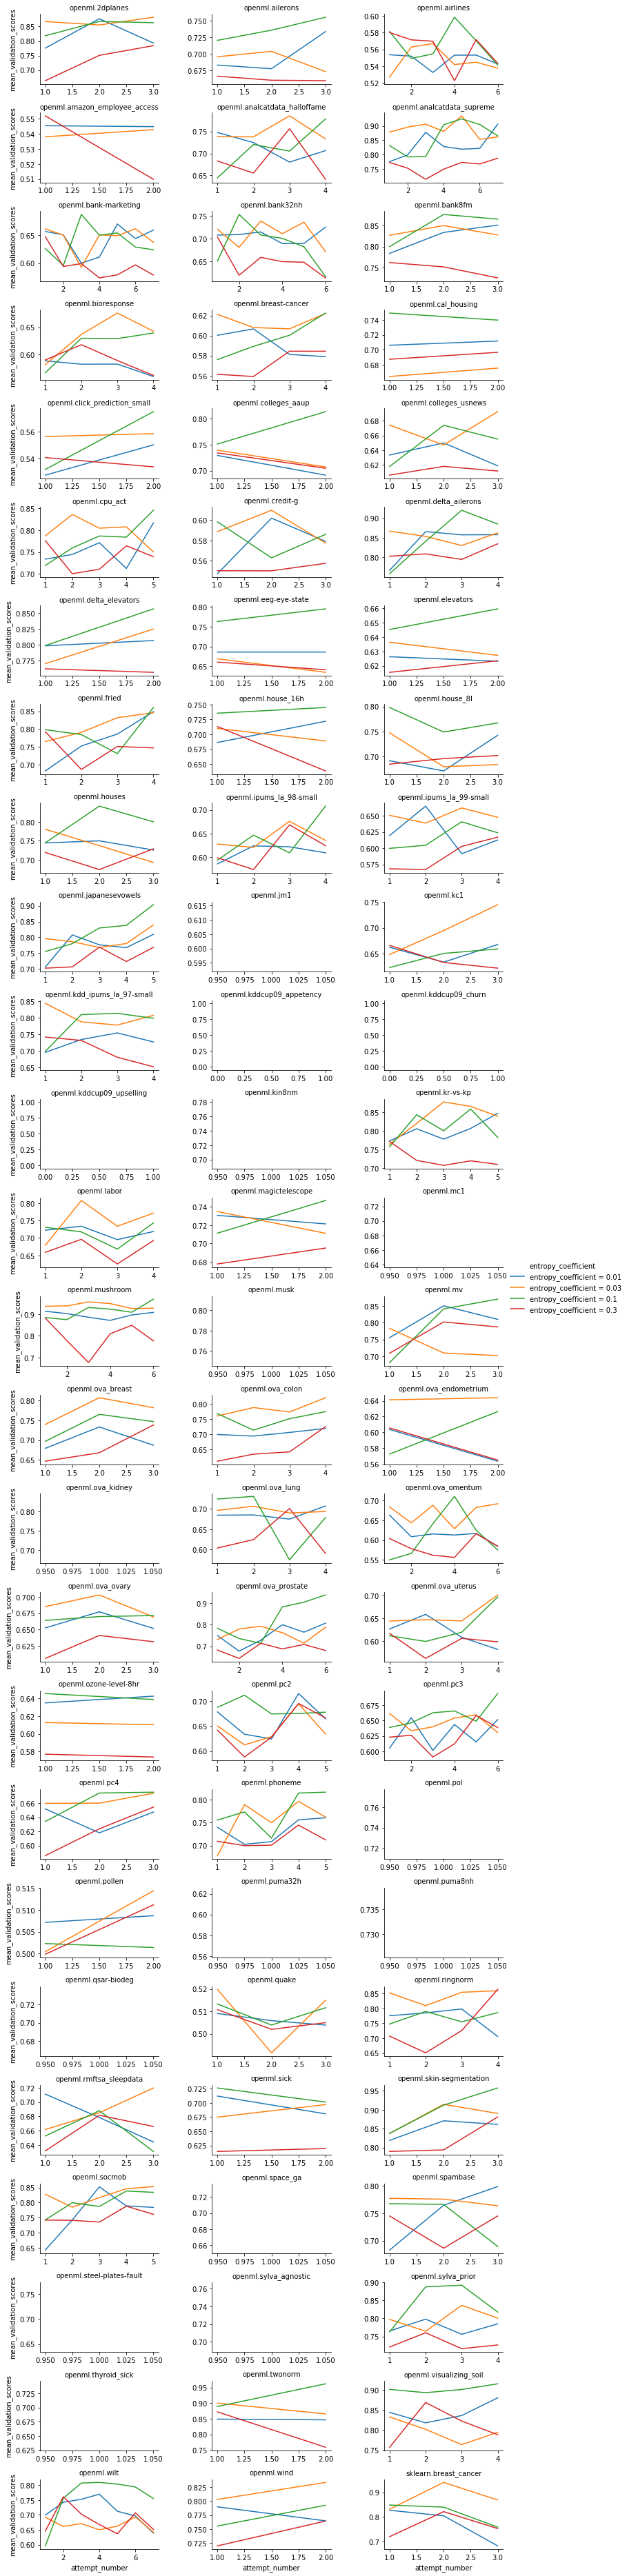

In [32]:
g = sns.relplot(
    x="attempt_number",
    y="mean_validation_scores",
    kind="line",
    data=(
        training_results
        .groupby(["data_env_names", "trial_num"])
        .apply(lambda df: df.assign(attempt_number=range(1, df.shape[0] + 1)))
        .reset_index(drop=True)
        .assign(entropy_coefficient=lambda df: "entropy_coefficient = " + df.entropy_coefficient.astype(str))
    ),
    col="data_env_names",
    col_wrap=3,
    hue="entropy_coefficient",
    height=2,
    aspect=1.75,
    facet_kws={
        "sharex": False,
        "sharey": False,
    }
)
g.set_titles("{col_name}")

## Inference

In [5]:
check_betw_zero_one = pa.Check(lambda s: (0.0 <= s) & (s <= 1.0))

INFERENCE_RESULT_SCHEMA = pa.DataFrameSchema(
    columns={
        "data_env": pa.Column(pa.String),
        "n_inference_steps": pa.Column(pa.Int),
        "is_valid": pa.Column(pa.Bool),
        "reward": pa.Column(pa.Float),
        "validation_score": pa.Column(pa.Float),
    },
    coerce=True,
)

@pa.check_output(INFERENCE_RESULT_SCHEMA)
def data_to_longform(inference_results):
    df = (
        inference_results
        [["data_env_partition", "trial_num",
          "data_env", "n_inference_steps", "key", "value"]]
        .pivot_table(
            index=[
                "data_env_partition", "trial_num",
                "data_env", "n_inference_steps",
            ],
            columns="key",
            values="value",
            aggfunc=lambda x: x,
        )
        .reset_index()
    )
    return (
        df
        .loc[
            lambda df: (
                # all scores should be strings
                df.validation_score.map(lambda x: isinstance(x, str)) &
                df.mlf.map(lambda x: isinstance(x, str)) &
                df.reward.map(lambda x: isinstance(x, str)) &
                df.is_valid.map(lambda x: isinstance(x, str))
            )
        ]
        .rename_axis(None, axis=1)
        .reset_index(drop=True)
    )

In [12]:
with tarfile.open(OUTPUT_PATH) as tar:
    inference_results = (
        pd.concat([
            (
                pd.read_csv(tar.extractfile(member))
                .assign(
                    data_env_partition=env,
                    trial_num=int(
                        re.search(
                            r".+_trial_(?P<trial_num>[0-9])\.csv",
                            str(member.name)
                        ).group("trial_num")
                    )
                )
            )
            for env in ["training", "test"]
            for member in (
                m for m in tar.getmembers()
                if m.name.startswith(f"./{env}_env_inference_results_trial_")
            )
        ])
        .pipe(data_to_longform)
        .sort_values(["data_env_partition", "trial_num", "n_inference_steps"])
        # add exponentially-weighted metrics
        .groupby(["data_env_partition", "data_env"])
        .apply(
            lambda group: group.assign(
                ewm_validation_score=group.ewm(span=30).validation_score.mean()
            )
        )
        .reset_index(drop=True)
        .assign(
            ewm_validation_score_centered=lambda df: (
                df.ewm_validation_score - (
                    df.groupby(["data_env_partition", "data_env"])
                    .ewm_validation_score.transform("first")
                )
            ),
            entropy_coefficient=lambda df: df.trial_num.map(lambda x: trial_num_map[x]["entropy_coefficient"]),
            target_type=lambda df: df.target_type.str.replace("^TargetType.", "")
        )
    )

inference_results.head()

,data_env_partition,trial_num,data_env,n_inference_steps,is_valid,mlf,mlf_full,reward,scorer,target_type,validation_score,ewm_validation_score,ewm_validation_score_centered,entropy_coefficient
0,test,3,kaggle.homesite_quote_conversion,12,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.767446,roc_auc,BINARY,0.767446,0.767446,0.000000,0.30
1,test,3,kaggle.homesite_quote_conversion,25,True,SimpleImputer > OneHotEncoder > RobustScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.500000,roc_auc,BINARY,0.500000,0.629265,-0.138180,0.30
2,test,3,kaggle.homesite_quote_conversion,34,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.500000,roc_auc,BINARY,0.500000,0.583274,-0.184172,0.30
3,test,0,kaggle.house_prices_advanced_regression_techni...,7,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.000000,r2,REGRESSION,-1.409887,-1.409887,0.000000,0.01
4,test,0,kaggle.house_prices_advanced_regression_techni...,14,True,SimpleImputer > OneHotEncoder > RobustScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.474636,r2,REGRESSION,0.474636,-0.436217,0.973670,0.01


## Plot Best Validation Scores on Training and Test Dataset Splits

In [13]:
total_n_shots = inference_results.n_inference_steps.max()
display(Markdown(f"Number of shots per trial: {total_n_shots}"))

Number of shots per trial: 49

Compute the cumulative reward per dataset and hyperparameter condition.

In [14]:
GROUPBY_COLS = ["data_env_partition", "trial_num", "target_type", "entropy_coefficient"]

inference_results_cum_reward = (
    inference_results
    .groupby(GROUPBY_COLS + ["n_inference_steps"])
    .agg({"reward": ["mean"], "mlf": ["count", "nunique"]})
    .set_axis(
        ["mean_reward", "n_successful_mlfs", "n_unique_mlfs"],
        axis="columns", inplace=False)
    .reset_index()
    .groupby(GROUPBY_COLS)
    .apply(
        lambda df: (
            df.sort_values("n_inference_steps")
            .assign(
                cumulative_reward=lambda x: x.mean_reward.cumsum(),
                cumulative_n_successful_mlfs=lambda x: x.n_successful_mlfs.cumsum(),
            )
        )
    )
    .reset_index(drop=True)
)

inference_results_cum_reward.head()

,data_env_partition,trial_num,target_type,entropy_coefficient,n_inference_steps,mean_reward,n_successful_mlfs,n_unique_mlfs,cumulative_reward,cumulative_n_successful_mlfs
0,test,0,BINARY,0.01,0,0.700947,7,7,0.700947,7
1,test,0,BINARY,0.01,1,0.818357,9,8,1.519304,16
2,test,0,BINARY,0.01,2,0.667107,7,7,2.186411,23
3,test,0,BINARY,0.01,3,0.781748,14,9,2.968159,37
4,test,0,BINARY,0.01,4,0.724960,17,15,3.693119,54


### N-shot Learning Metrics

Evaluate the performance of each learning rate on the training dataset and
test dataset splits to assess generalization performance of the metalearning
system.

#### Cumulative Reward

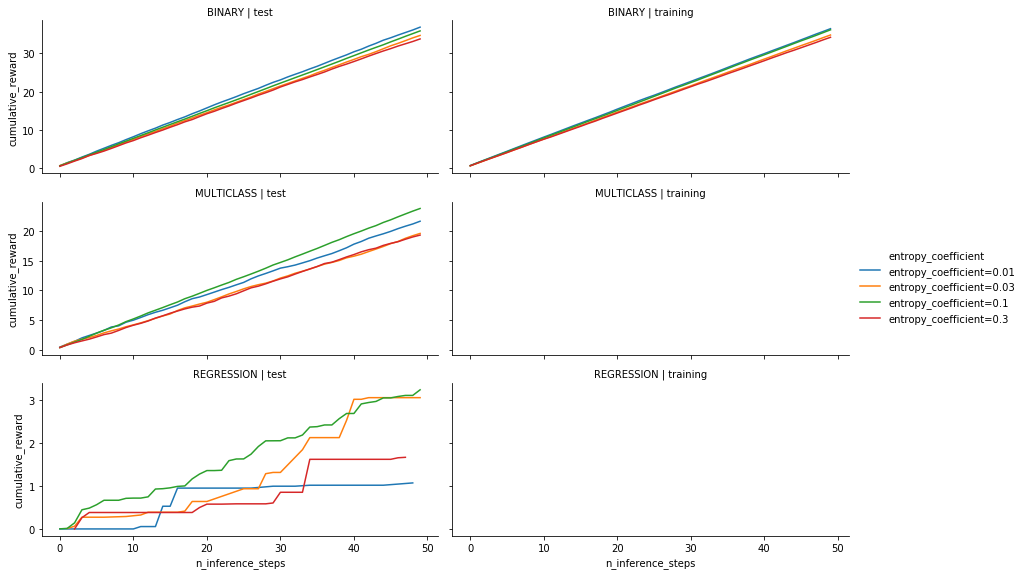

In [15]:
g = sns.relplot(
    x="n_inference_steps",
    y="cumulative_reward",
    hue="entropy_coefficient",
    col="data_env_partition",
    row="target_type",
    row_order=["BINARY", "MULTICLASS", "REGRESSION"],
    kind="line",
    data=(
        inference_results_cum_reward
        .assign(
            entropy_coefficient=lambda df: "entropy_coefficient=" + df.entropy_coefficient.astype(str)
        )

    ),
    height=2.7,
    aspect=2.25,
    facet_kws={
        "sharey": "row",
    }
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

#### Validation Scores

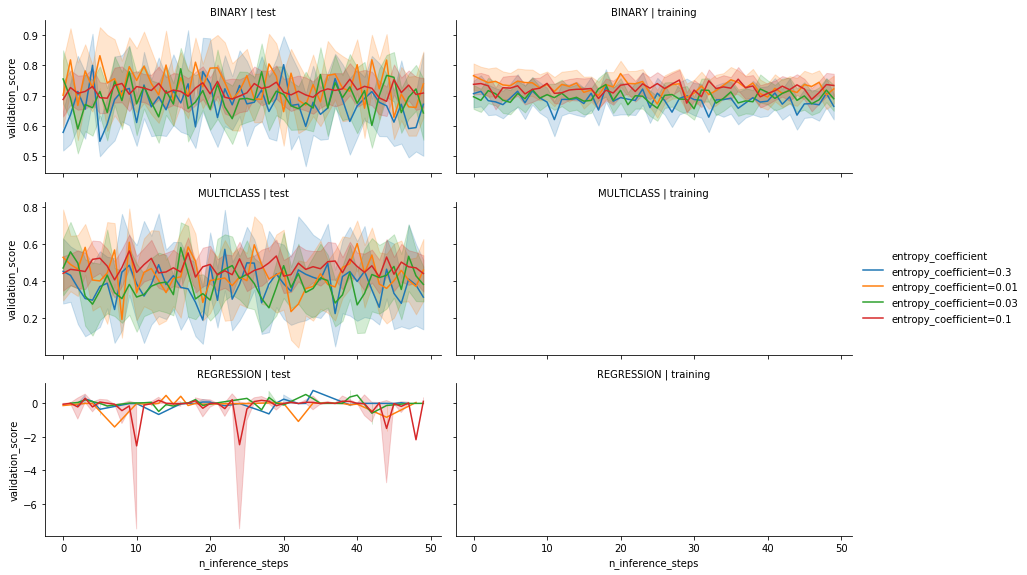

In [31]:
g = sns.relplot(
    x="n_inference_steps",
    y="validation_score",
    hue="entropy_coefficient",
    col="data_env_partition",
    row="target_type",
    row_order=["BINARY", "MULTICLASS", "REGRESSION"],
    kind="line",
    data=(
        inference_results.assign(
            entropy_coefficient=lambda df: "entropy_coefficient=" + df.entropy_coefficient.astype(str),
            # clip regression validation scores to a min of -10
            validation_score=lambda df: df.validation_score.where(df.validation_score > -10, -10)
        )
    ),
    height=2.7,
    aspect=2.25,
    facet_kws={
        "sharey": "row",
    }
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

#### Cumulative Sum of Successful ML Frameworks

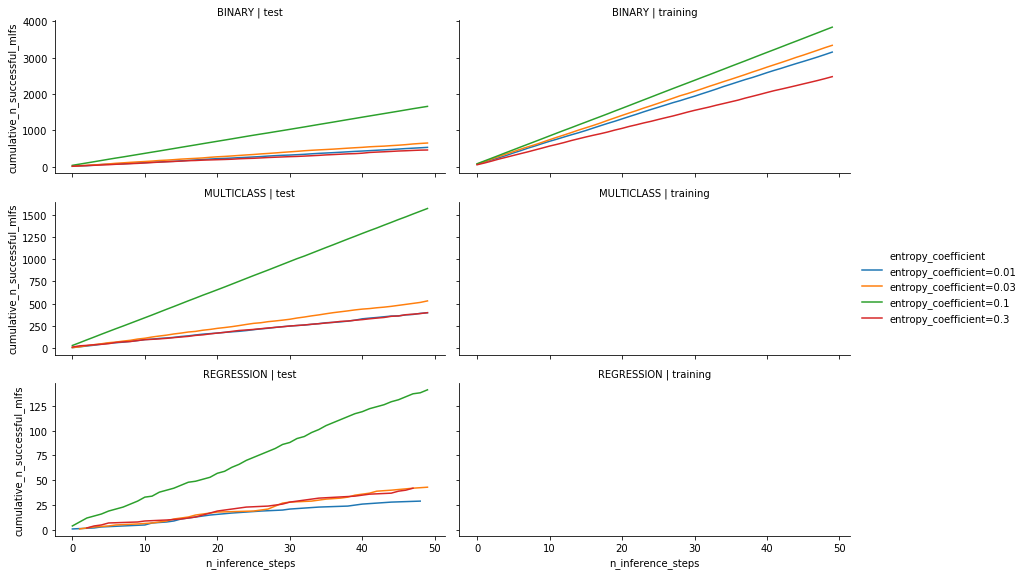

In [29]:
g = sns.relplot(
    x="n_inference_steps",
    y="cumulative_n_successful_mlfs",
    hue="entropy_coefficient",
    col="data_env_partition",
    row="target_type",
    row_order=["BINARY", "MULTICLASS", "REGRESSION"],
    kind="line",
    data=(
        inference_results_cum_reward
        .assign(
            entropy_coefficient=lambda df: "entropy_coefficient=" + df.entropy_coefficient.astype(str)
        )

    ),
    height=2.7,
    aspect=2.25,
    facet_kws={
        "sharey": "row",
    }
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

#### Number of Unique ML Frameworks

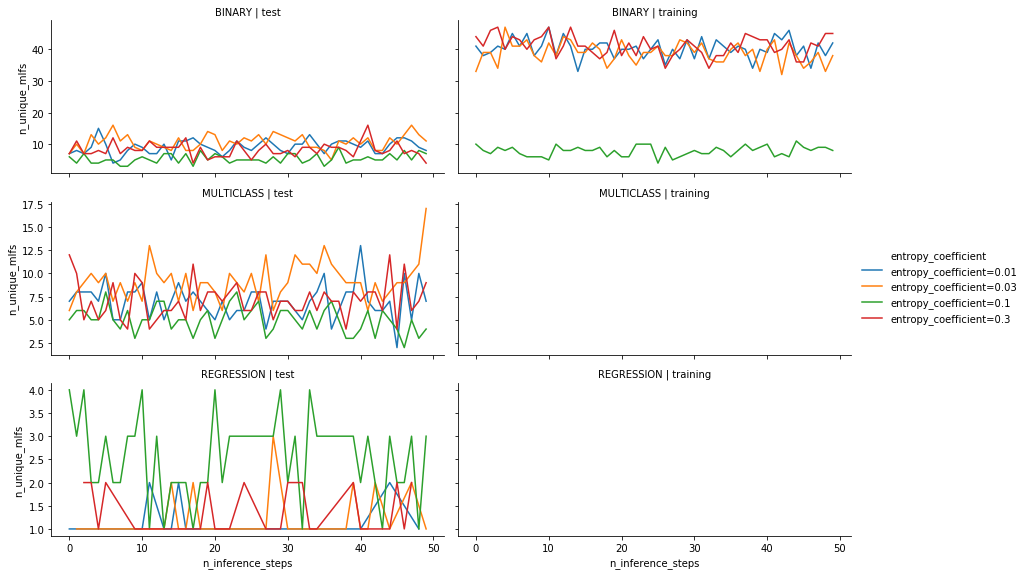

In [30]:
g = sns.relplot(
    x="n_inference_steps",
    y="n_unique_mlfs",
    hue="entropy_coefficient",
    col="data_env_partition",
    row="target_type",
    row_order=["BINARY", "MULTICLASS", "REGRESSION"],
    kind="line",
    data=(
        inference_results_cum_reward
        .assign(
            entropy_coefficient=lambda df: "entropy_coefficient=" + df.entropy_coefficient.astype(str)
        )

    ),
    height=2.7,
    aspect=2.25,
    facet_kws={
        "sharey": "row",
    }
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")